In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm, trange


from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
raw_data1 = pd.read_csv("data/train01.csv", sep=";")
raw_data2 = pd.read_csv("data/train02.csv", sep=";")
test = pd.read_csv("data/test.csv", sep=";")

In [3]:
raw_data = pd.concat([raw_data1, raw_data2])

In [4]:
raw_data.loc[~raw_data["x2"].isnull(), "x2"] = raw_data.loc[~raw_data["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y").date())
test.loc[~test["x2"].isnull(), "x2"] = test.loc[~test["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [5]:
def str2list(s, sep=None):
    return list(map(float, s[1:-1].split(sep)))


raw_data.drop(["x8", "x9"], axis=1, inplace=True)
test.drop(["x8", "x9"], axis=1, inplace=True)

# train.x8 = train.x8.apply(str2list)
# train.x9 = train.x9.apply(str2list)

for idx in trange(10, 43):
    raw_data[f"x{idx}"] = raw_data[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))
    test[f"x{idx}"] = test[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))

  0%|          | 0/33 [00:00<?, ?it/s]

<BarContainer object of 41 artists>

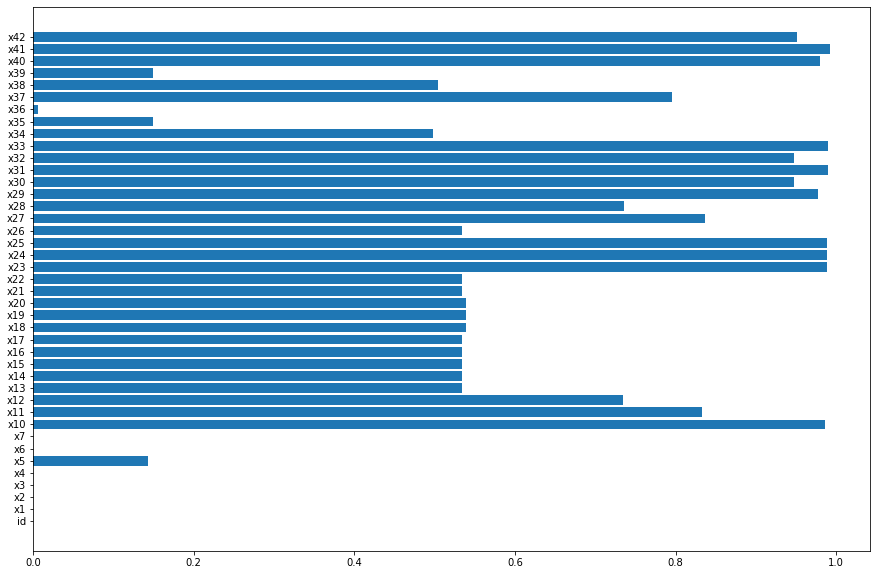

In [6]:
fig = plt.figure(figsize=(15, 10))

nans = {}
for col in raw_data.columns:
    if col == "y":
        continue
    nans[col] = raw_data[col].explode().isnull().mean()

plt.barh(list(nans.keys()), list(nans.values()))

In [7]:
for key, value in nans.items():
    if value >= 0.6:
        raw_data.drop(key, axis=1, inplace=True)
        test.drop(key, axis=1, inplace=True)

In [8]:
raw_data

,id,y,x1,x2,x3,x4,x5,x6,x7,x13,...,x19,x20,x21,x22,x26,x34,x35,x36,x38,x39
0,-9196902500682081904,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,2066976859146697559,0,"[nan, 1.0, nan, nan, 1.0, 1.0]",...,"[nan, 0.02, nan, nan, 47.67, 70.6]","[nan, 0.28, nan, nan, 0.0, 9969.07]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[3.0, 2.0, 1.0, nan, nan, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
1,-9196902500682081900,0,-2201458060675810556,2013-02-05,4293238556669161936,182,-8.465179e+18,-8648529837587014226,0,"[nan, nan, 0.0, 0.0, nan, 0.0]",...,"[nan, nan, 0.0, 0.13, nan, 0.0]","[nan, nan, 0.02, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[4.0, nan, nan, 2.0, 3.0, 7.0]","[90.27, 90.27, 90.27, 90.27, 90.27, 90.27]","[249.94, 249.94, 249.94, 249.94, 155.64, 155.64]","[nan, nan, nan, nan, nan, nan]","[103.09, 103.09, 103.09, 103.09, 103.09, 103.09]"
2,-9196902500682081899,0,-2201458060675810556,2008-09-01,6312572492787112517,175,5.417474e+18,-5480331477604673780,1,"[nan, 0.0, nan, nan, nan, nan]",...,"[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, 2.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[196.61, 224.79, 197.55, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
3,-9196902500682081897,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,-3150357754345161454,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[nan, nan, nan, 1.0, 2.0, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[199.65, 199.65, 199.65, 199.65, 199.65, 199.65]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
4,-9196902500681081897,0,-2201458060675810556,2008-09-01,6312572492787112517,179,6.856367e+18,4900304581511328621,2,"[nan, 0.0, nan, 0.0, nan, nan]",...,"[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[3.0, nan, 2.0, nan, 1.0, 5.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93184,9162040885608725764,0,-4849479253074186081,2011-12-21,6312572492787112517,167,7.599054e+18,2066976859146697559,1,"[0.0, 0.0, 0.0, 0.0, nan, nan]",...,"[0.0, 0.0, 0.0, 0.01, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[3.0, nan, 3.0, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[149.36, 149.36, 149.36, 99.49, 149.36, 149.36]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
93185,9162040885608725769,0,-4849479253074186081,2016-08-25,6312572492787112517,8,7.599054e+18,-2615825110734950454,0,"[nan, nan, nan, nan, nan, 0.0]",...,"[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[1.0, 1.0, nan, 1.0, 2.0, 2.0]","[nan, nan, nan, nan, nan, 67.64]","[61.35, 61.35, 61.35, 61.35, 61.35, 61.35]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, 80.46]"
93186,9162040885608725770,0,-4849479253074186081,2013-12-02,6312572492787112517,184,7.599054e+18,2066976859146697559,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.41, 0.31, 0.0, 0.0, 0.46

In [9]:
def agregate(df):
    for col in df.loc[:, "x13":].columns:
        x = np.array(df[col].tolist())

        min_ = np.nanmin(x, axis=1, keepdims=True)
        max_ = np.nanmax(x, axis=1, keepdims=True)
        mean = np.nanmean(x, axis=1, keepdims=True)
        std = np.nanstd(x, axis=1, keepdims=True)
        p = np.isnan(x).mean(1, keepdims=True)

        x[np.isnan(x)] = 0

        x = np.hstack([x, min_, max_, mean, std, p])

        names = [f"{col}_{i}" for i in range(1, 7)] + \
                [f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std", f"{col}_nans"]

        df[names] = x

        df.drop(col, axis=1, inplace=True)
        
        
def fill_null(df):
    df.loc[df["x2"].isnull(), "x2"] = datetime(1, 1, 1, 0, 0, 0).date()
    df.loc[df["x1"].isnull(), "x1"] = 0
    df.loc[df["x3"].isnull(), "x3"] = 0
    df.loc[df["x5"].isnull(), "x5"] = 0
    df.loc[df["x6"].isnull(), "x6"] = 0
    
    
def convert_str(df):
    df.x1 = df.x1.astype(str)
    df.x3 = df.x3.astype(str)
    df.x5 = df.x5.astype(str)
    df.x6 = df.x6.astype(str)
    

def convert_date(df):
    df['x2_month'] = df['x2'].apply(lambda x: x.month)
    df['x2_day'] = df['x2'].apply(lambda x: x.day)
    df.drop("x2", axis=1, inplace=True)

In [10]:
agregate(raw_data)
agregate(test)

/tmp/ipykernel_25670/3158839329.py:5: RuntimeWarning: All-NaN slice encountered
  min_ = np.nanmin(x, axis=1, keepdims=True)
/tmp/ipykernel_25670/3158839329.py:6: RuntimeWarning: All-NaN slice encountered
  max_ = np.nanmax(x, axis=1, keepdims=True)
/tmp/ipykernel_25670/3158839329.py:7: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x, axis=1, keepdims=True)
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [11]:
fill_null(raw_data)
fill_null(test)

convert_str(raw_data)
convert_str(test)

convert_date(raw_data)
convert_date(test)

In [12]:
unique_ids = pd.unique(raw_data.id)

N = unique_ids.shape[0]

print(N)

train_ids = np.random.choice(unique_ids, size=int(0.95 * N), replace=False)

train = raw_data[raw_data.id.isin(train_ids)].drop(["id", "y"], axis=1).copy().values
y_train = raw_data[raw_data.id.isin(train_ids)]["y"].copy().values

val = raw_data[~raw_data.id.isin(train_ids)].drop(["id", "y"], axis=1).copy().values
y_val = raw_data[~raw_data.id.isin(train_ids)]["y"].copy().values

119967


In [13]:
cat = CatBoostClassifier(task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5])

Learning rate set to 0.025368
0:	learn: 0.6436472	total: 25ms	remaining: 25s
1:	learn: 0.5984127	total: 48.6ms	remaining: 24.3s
2:	learn: 0.5569506	total: 71ms	remaining: 23.6s
3:	learn: 0.5206323	total: 94.6ms	remaining: 23.6s
4:	learn: 0.4867372	total: 118ms	remaining: 23.5s
5:	learn: 0.4547528	total: 140ms	remaining: 23.2s
6:	learn: 0.4255508	total: 164ms	remaining: 23.3s
7:	learn: 0.3993272	total: 188ms	remaining: 23.3s
8:	learn: 0.3747007	total: 211ms	remaining: 23.2s
9:	learn: 0.3524598	total: 234ms	remaining: 23.1s
10:	learn: 0.3322629	total: 255ms	remaining: 23s
11:	learn: 0.3136064	total: 273ms	remaining: 22.5s
12:	learn: 0.2967643	total: 290ms	remaining: 22s
13:	learn: 0.2813853	total: 305ms	remaining: 21.5s
14:	learn: 0.2673096	total: 321ms	remaining: 21.1s
15:	learn: 0.2544901	total: 338ms	remaining: 20.8s
16:	learn: 0.2426628	total: 354ms	remaining: 20.4s
17:	learn: 0.2320367	total: 370ms	remaining: 20.2s
18:	learn: 0.2222878	total: 388ms	remaining: 20s
19:	learn: 0.213408

160:	learn: 0.0809272	total: 2.92s	remaining: 15.2s
161:	learn: 0.0808738	total: 2.95s	remaining: 15.2s
162:	learn: 0.0808243	total: 2.97s	remaining: 15.2s
163:	learn: 0.0807667	total: 3s	remaining: 15.3s
164:	learn: 0.0806897	total: 3.02s	remaining: 15.3s
165:	learn: 0.0805918	total: 3.04s	remaining: 15.3s
166:	learn: 0.0804313	total: 3.06s	remaining: 15.3s
167:	learn: 0.0803833	total: 3.08s	remaining: 15.3s
168:	learn: 0.0803285	total: 3.11s	remaining: 15.3s
169:	learn: 0.0802568	total: 3.13s	remaining: 15.3s
170:	learn: 0.0802013	total: 3.15s	remaining: 15.3s
171:	learn: 0.0801519	total: 3.17s	remaining: 15.3s
172:	learn: 0.0800027	total: 3.19s	remaining: 15.3s
173:	learn: 0.0799587	total: 3.21s	remaining: 15.3s
174:	learn: 0.0799112	total: 3.23s	remaining: 15.3s
175:	learn: 0.0797688	total: 3.25s	remaining: 15.2s
176:	learn: 0.0797079	total: 3.27s	remaining: 15.2s
177:	learn: 0.0796492	total: 3.29s	remaining: 15.2s
178:	learn: 0.0795871	total: 3.31s	remaining: 15.2s
179:	learn: 0.0

322:	learn: 0.0742840	total: 6.07s	remaining: 12.7s
323:	learn: 0.0742783	total: 6.09s	remaining: 12.7s
324:	learn: 0.0742771	total: 6.11s	remaining: 12.7s
325:	learn: 0.0742748	total: 6.13s	remaining: 12.7s
326:	learn: 0.0742738	total: 6.15s	remaining: 12.7s
327:	learn: 0.0742588	total: 6.17s	remaining: 12.7s
328:	learn: 0.0742563	total: 6.2s	remaining: 12.6s
329:	learn: 0.0742387	total: 6.21s	remaining: 12.6s
330:	learn: 0.0742352	total: 6.23s	remaining: 12.6s
331:	learn: 0.0742314	total: 6.25s	remaining: 12.6s
332:	learn: 0.0742298	total: 6.26s	remaining: 12.5s
333:	learn: 0.0742136	total: 6.28s	remaining: 12.5s
334:	learn: 0.0741835	total: 6.3s	remaining: 12.5s
335:	learn: 0.0741723	total: 6.32s	remaining: 12.5s
336:	learn: 0.0741592	total: 6.33s	remaining: 12.5s
337:	learn: 0.0741153	total: 6.35s	remaining: 12.4s
338:	learn: 0.0740970	total: 6.37s	remaining: 12.4s
339:	learn: 0.0740928	total: 6.39s	remaining: 12.4s
340:	learn: 0.0740893	total: 6.41s	remaining: 12.4s
341:	learn: 0.

482:	learn: 0.0726901	total: 9.2s	remaining: 9.84s
483:	learn: 0.0726861	total: 9.22s	remaining: 9.82s
484:	learn: 0.0726845	total: 9.24s	remaining: 9.81s
485:	learn: 0.0726782	total: 9.26s	remaining: 9.79s
486:	learn: 0.0726775	total: 9.28s	remaining: 9.77s
487:	learn: 0.0726768	total: 9.29s	remaining: 9.75s
488:	learn: 0.0726760	total: 9.31s	remaining: 9.73s
489:	learn: 0.0726645	total: 9.33s	remaining: 9.71s
490:	learn: 0.0726569	total: 9.35s	remaining: 9.7s
491:	learn: 0.0726554	total: 9.37s	remaining: 9.68s
492:	learn: 0.0726547	total: 9.39s	remaining: 9.66s
493:	learn: 0.0726494	total: 9.41s	remaining: 9.64s
494:	learn: 0.0726448	total: 9.43s	remaining: 9.62s
495:	learn: 0.0726407	total: 9.45s	remaining: 9.61s
496:	learn: 0.0726033	total: 9.47s	remaining: 9.59s
497:	learn: 0.0725654	total: 9.49s	remaining: 9.57s
498:	learn: 0.0725651	total: 9.51s	remaining: 9.55s
499:	learn: 0.0725642	total: 9.53s	remaining: 9.53s
500:	learn: 0.0725618	total: 9.55s	remaining: 9.51s
501:	learn: 0.

644:	learn: 0.0716680	total: 12.4s	remaining: 6.81s
645:	learn: 0.0716627	total: 12.4s	remaining: 6.79s
646:	learn: 0.0716620	total: 12.4s	remaining: 6.78s
647:	learn: 0.0716607	total: 12.4s	remaining: 6.75s
648:	learn: 0.0716455	total: 12.5s	remaining: 6.74s
649:	learn: 0.0716447	total: 12.5s	remaining: 6.72s
650:	learn: 0.0716439	total: 12.5s	remaining: 6.7s
651:	learn: 0.0716395	total: 12.5s	remaining: 6.68s
652:	learn: 0.0716393	total: 12.5s	remaining: 6.66s
653:	learn: 0.0716358	total: 12.6s	remaining: 6.64s
654:	learn: 0.0716348	total: 12.6s	remaining: 6.63s
655:	learn: 0.0716317	total: 12.6s	remaining: 6.61s
656:	learn: 0.0716309	total: 12.6s	remaining: 6.58s
657:	learn: 0.0716290	total: 12.6s	remaining: 6.57s
658:	learn: 0.0716284	total: 12.6s	remaining: 6.54s
659:	learn: 0.0716270	total: 12.7s	remaining: 6.52s
660:	learn: 0.0716267	total: 12.7s	remaining: 6.5s
661:	learn: 0.0716205	total: 12.7s	remaining: 6.48s
662:	learn: 0.0716182	total: 12.7s	remaining: 6.46s
663:	learn: 0.

813:	learn: 0.0706218	total: 15.5s	remaining: 3.55s
814:	learn: 0.0706212	total: 15.5s	remaining: 3.53s
815:	learn: 0.0705839	total: 15.6s	remaining: 3.51s
816:	learn: 0.0705810	total: 15.6s	remaining: 3.49s
817:	learn: 0.0705775	total: 15.6s	remaining: 3.47s
818:	learn: 0.0705763	total: 15.6s	remaining: 3.45s
819:	learn: 0.0705492	total: 15.6s	remaining: 3.43s
820:	learn: 0.0705481	total: 15.7s	remaining: 3.42s
821:	learn: 0.0705473	total: 15.7s	remaining: 3.4s
822:	learn: 0.0705250	total: 15.7s	remaining: 3.38s
823:	learn: 0.0705223	total: 15.7s	remaining: 3.36s
824:	learn: 0.0705126	total: 15.7s	remaining: 3.34s
825:	learn: 0.0705022	total: 15.8s	remaining: 3.32s
826:	learn: 0.0705000	total: 15.8s	remaining: 3.3s
827:	learn: 0.0704952	total: 15.8s	remaining: 3.28s
828:	learn: 0.0704944	total: 15.8s	remaining: 3.26s
829:	learn: 0.0704931	total: 15.8s	remaining: 3.24s
830:	learn: 0.0704926	total: 15.8s	remaining: 3.22s
831:	learn: 0.0704901	total: 15.9s	remaining: 3.2s
832:	learn: 0.0

972:	learn: 0.0698986	total: 18.5s	remaining: 513ms
973:	learn: 0.0698981	total: 18.5s	remaining: 494ms
974:	learn: 0.0698972	total: 18.5s	remaining: 475ms
975:	learn: 0.0698964	total: 18.5s	remaining: 456ms
976:	learn: 0.0698956	total: 18.5s	remaining: 437ms
977:	learn: 0.0698951	total: 18.6s	remaining: 417ms
978:	learn: 0.0698927	total: 18.6s	remaining: 398ms
979:	learn: 0.0698868	total: 18.6s	remaining: 379ms
980:	learn: 0.0698853	total: 18.6s	remaining: 360ms
981:	learn: 0.0698832	total: 18.6s	remaining: 341ms
982:	learn: 0.0698823	total: 18.6s	remaining: 322ms
983:	learn: 0.0698800	total: 18.7s	remaining: 303ms
984:	learn: 0.0698710	total: 18.7s	remaining: 285ms
985:	learn: 0.0698678	total: 18.7s	remaining: 266ms
986:	learn: 0.0698663	total: 18.7s	remaining: 247ms
987:	learn: 0.0698595	total: 18.7s	remaining: 228ms
988:	learn: 0.0698567	total: 18.8s	remaining: 209ms
989:	learn: 0.0698532	total: 18.8s	remaining: 190ms
990:	learn: 0.0698503	total: 18.8s	remaining: 171ms
991:	learn: 

In [14]:
y_pred_proba = cat.predict_proba(val)
y_pred = cat.predict(val)
roc_auc_score(y_val, y_pred_proba[:, 1])

0.915924568835993

In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8998
           1       0.91      0.30      0.45       233

    accuracy                           0.98      9231
   macro avg       0.94      0.65      0.72      9231
weighted avg       0.98      0.98      0.98      9231



CROSS-VAL

In [16]:
# cat = CatBoostClassifier(task_type="GPU", cat_features=[0, 1, 2, 4, 5])
# scores = cross_val_score(cat, train, y_train, scoring="roc_auc")

In [17]:
# print(scores)
# print(np.mean(scores))

Train on whole dataset

In [18]:
train = raw_data.drop(["id", "y"], axis=1).copy().values
y_train = raw_data["y"].copy().values

In [19]:
cat = CatBoostClassifier(task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5])

Learning rate set to 0.025297
0:	learn: 0.6438577	total: 21.1ms	remaining: 21.1s
1:	learn: 0.5986523	total: 40ms	remaining: 19.9s
2:	learn: 0.5584945	total: 58.3ms	remaining: 19.4s
3:	learn: 0.5220197	total: 78.5ms	remaining: 19.5s
4:	learn: 0.4868326	total: 97.8ms	remaining: 19.5s
5:	learn: 0.4550767	total: 118ms	remaining: 19.6s
6:	learn: 0.4259107	total: 137ms	remaining: 19.5s
7:	learn: 0.3996213	total: 158ms	remaining: 19.6s
8:	learn: 0.3753918	total: 177ms	remaining: 19.5s
9:	learn: 0.3533357	total: 195ms	remaining: 19.3s
10:	learn: 0.3329595	total: 215ms	remaining: 19.3s
11:	learn: 0.3143037	total: 232ms	remaining: 19.1s
12:	learn: 0.2974137	total: 249ms	remaining: 18.9s
13:	learn: 0.2819474	total: 266ms	remaining: 18.7s
14:	learn: 0.2679438	total: 283ms	remaining: 18.6s
15:	learn: 0.2551207	total: 301ms	remaining: 18.5s
16:	learn: 0.2433446	total: 319ms	remaining: 18.4s
17:	learn: 0.2326941	total: 337ms	remaining: 18.4s
18:	learn: 0.2229487	total: 353ms	remaining: 18.2s
19:	lear

160:	learn: 0.0807560	total: 2.93s	remaining: 15.3s
161:	learn: 0.0806901	total: 2.95s	remaining: 15.3s
162:	learn: 0.0806623	total: 2.96s	remaining: 15.2s
163:	learn: 0.0804935	total: 2.98s	remaining: 15.2s
164:	learn: 0.0803370	total: 3s	remaining: 15.2s
165:	learn: 0.0801882	total: 3.02s	remaining: 15.2s
166:	learn: 0.0801332	total: 3.04s	remaining: 15.2s
167:	learn: 0.0800804	total: 3.06s	remaining: 15.1s
168:	learn: 0.0799386	total: 3.08s	remaining: 15.1s
169:	learn: 0.0798917	total: 3.09s	remaining: 15.1s
170:	learn: 0.0798141	total: 3.11s	remaining: 15.1s
171:	learn: 0.0797568	total: 3.13s	remaining: 15.1s
172:	learn: 0.0797122	total: 3.15s	remaining: 15.1s
173:	learn: 0.0796556	total: 3.17s	remaining: 15s
174:	learn: 0.0796035	total: 3.19s	remaining: 15s
175:	learn: 0.0795680	total: 3.21s	remaining: 15s
176:	learn: 0.0795586	total: 3.22s	remaining: 15s
177:	learn: 0.0795072	total: 3.24s	remaining: 15s
178:	learn: 0.0793704	total: 3.26s	remaining: 15s
179:	learn: 0.0792492	total

325:	learn: 0.0739727	total: 6.01s	remaining: 12.4s
326:	learn: 0.0739201	total: 6.03s	remaining: 12.4s
327:	learn: 0.0739151	total: 6.05s	remaining: 12.4s
328:	learn: 0.0739114	total: 6.07s	remaining: 12.4s
329:	learn: 0.0739019	total: 6.09s	remaining: 12.4s
330:	learn: 0.0738844	total: 6.11s	remaining: 12.3s
331:	learn: 0.0738830	total: 6.13s	remaining: 12.3s
332:	learn: 0.0738355	total: 6.15s	remaining: 12.3s
333:	learn: 0.0738341	total: 6.17s	remaining: 12.3s
334:	learn: 0.0738314	total: 6.19s	remaining: 12.3s
335:	learn: 0.0738296	total: 6.2s	remaining: 12.3s
336:	learn: 0.0738257	total: 6.22s	remaining: 12.2s
337:	learn: 0.0738202	total: 6.24s	remaining: 12.2s
338:	learn: 0.0738176	total: 6.25s	remaining: 12.2s
339:	learn: 0.0738163	total: 6.27s	remaining: 12.2s
340:	learn: 0.0738133	total: 6.29s	remaining: 12.2s
341:	learn: 0.0737798	total: 6.31s	remaining: 12.1s
342:	learn: 0.0737784	total: 6.33s	remaining: 12.1s
343:	learn: 0.0737741	total: 6.34s	remaining: 12.1s
344:	learn: 0

493:	learn: 0.0722037	total: 9.12s	remaining: 9.34s
494:	learn: 0.0721938	total: 9.13s	remaining: 9.32s
495:	learn: 0.0721918	total: 9.15s	remaining: 9.3s
496:	learn: 0.0721905	total: 9.17s	remaining: 9.29s
497:	learn: 0.0721900	total: 9.19s	remaining: 9.27s
498:	learn: 0.0721889	total: 9.21s	remaining: 9.24s
499:	learn: 0.0721871	total: 9.23s	remaining: 9.23s
500:	learn: 0.0721867	total: 9.25s	remaining: 9.21s
501:	learn: 0.0721854	total: 9.27s	remaining: 9.2s
502:	learn: 0.0721839	total: 9.29s	remaining: 9.18s
503:	learn: 0.0721680	total: 9.31s	remaining: 9.16s
504:	learn: 0.0721358	total: 9.33s	remaining: 9.14s
505:	learn: 0.0721346	total: 9.35s	remaining: 9.12s
506:	learn: 0.0721322	total: 9.36s	remaining: 9.11s
507:	learn: 0.0721297	total: 9.38s	remaining: 9.09s
508:	learn: 0.0721288	total: 9.4s	remaining: 9.06s
509:	learn: 0.0721285	total: 9.42s	remaining: 9.05s
510:	learn: 0.0721259	total: 9.43s	remaining: 9.03s
511:	learn: 0.0721245	total: 9.45s	remaining: 9.01s
512:	learn: 0.0

652:	learn: 0.0712099	total: 12s	remaining: 6.4s
653:	learn: 0.0712058	total: 12.1s	remaining: 6.38s
654:	learn: 0.0712016	total: 12.1s	remaining: 6.36s
655:	learn: 0.0711985	total: 12.1s	remaining: 6.34s
656:	learn: 0.0711951	total: 12.1s	remaining: 6.32s
657:	learn: 0.0711944	total: 12.1s	remaining: 6.3s
658:	learn: 0.0711939	total: 12.1s	remaining: 6.29s
659:	learn: 0.0711931	total: 12.2s	remaining: 6.27s
660:	learn: 0.0711884	total: 12.2s	remaining: 6.25s
661:	learn: 0.0711871	total: 12.2s	remaining: 6.24s
662:	learn: 0.0711857	total: 12.2s	remaining: 6.22s
663:	learn: 0.0711837	total: 12.3s	remaining: 6.2s
664:	learn: 0.0711676	total: 12.3s	remaining: 6.18s
665:	learn: 0.0711672	total: 12.3s	remaining: 6.16s
666:	learn: 0.0711632	total: 12.3s	remaining: 6.14s
667:	learn: 0.0711437	total: 12.3s	remaining: 6.13s
668:	learn: 0.0711419	total: 12.4s	remaining: 6.11s
669:	learn: 0.0711390	total: 12.4s	remaining: 6.09s
670:	learn: 0.0711378	total: 12.4s	remaining: 6.08s
671:	learn: 0.071

815:	learn: 0.0703960	total: 15.3s	remaining: 3.46s
816:	learn: 0.0703682	total: 15.4s	remaining: 3.44s
817:	learn: 0.0703664	total: 15.4s	remaining: 3.42s
818:	learn: 0.0703631	total: 15.4s	remaining: 3.4s
819:	learn: 0.0703626	total: 15.4s	remaining: 3.38s
820:	learn: 0.0703483	total: 15.4s	remaining: 3.37s
821:	learn: 0.0703479	total: 15.5s	remaining: 3.35s
822:	learn: 0.0703461	total: 15.5s	remaining: 3.33s
823:	learn: 0.0703446	total: 15.5s	remaining: 3.31s
824:	learn: 0.0703247	total: 15.5s	remaining: 3.29s
825:	learn: 0.0703236	total: 15.5s	remaining: 3.27s
826:	learn: 0.0703230	total: 15.6s	remaining: 3.25s
827:	learn: 0.0703000	total: 15.6s	remaining: 3.24s
828:	learn: 0.0702911	total: 15.6s	remaining: 3.22s
829:	learn: 0.0702854	total: 15.6s	remaining: 3.2s
830:	learn: 0.0702813	total: 15.6s	remaining: 3.18s
831:	learn: 0.0702771	total: 15.7s	remaining: 3.16s
832:	learn: 0.0702745	total: 15.7s	remaining: 3.14s
833:	learn: 0.0702657	total: 15.7s	remaining: 3.13s
834:	learn: 0.

982:	learn: 0.0696610	total: 18.7s	remaining: 323ms
983:	learn: 0.0696584	total: 18.7s	remaining: 304ms
984:	learn: 0.0696561	total: 18.7s	remaining: 285ms
985:	learn: 0.0696546	total: 18.8s	remaining: 266ms
986:	learn: 0.0696511	total: 18.8s	remaining: 247ms
987:	learn: 0.0696480	total: 18.8s	remaining: 228ms
988:	learn: 0.0696460	total: 18.8s	remaining: 209ms
989:	learn: 0.0696455	total: 18.8s	remaining: 190ms
990:	learn: 0.0696440	total: 18.9s	remaining: 171ms
991:	learn: 0.0696427	total: 18.9s	remaining: 152ms
992:	learn: 0.0696417	total: 18.9s	remaining: 133ms
993:	learn: 0.0696325	total: 18.9s	remaining: 114ms
994:	learn: 0.0696241	total: 19s	remaining: 95.3ms
995:	learn: 0.0696228	total: 19s	remaining: 76.2ms
996:	learn: 0.0696214	total: 19s	remaining: 57.2ms
997:	learn: 0.0696208	total: 19s	remaining: 38.1ms
998:	learn: 0.0696171	total: 19s	remaining: 19.1ms
999:	learn: 0.0696054	total: 19.1s	remaining: 0us


Submission

In [20]:
test_data = test.values
test_ids = test['id'] = test.index

In [21]:
y_test = cat.predict_proba(test_data)

In [22]:
submission = pd.DataFrame({
    "id": test_ids,
    "y": y_test[:, 1]
})

submission.to_csv("submission.csv", sep=";", index=False)